In [11]:
from filterpy.kalman import MerweScaledSigmaPoints as SigmaPoints
 
mean = 0    # 均值
cov =  1    # 方差
#help(SigmaPoints)
points = SigmaPoints(n=1, alpha=0.1, beta=2.0, kappa=1.0)  
Wm=points.Wm
Wc=points.Wc
sigmas = points.sigma_points(mean, cov)
 
print (Wm, Wc)   # 计算均值和方差的权值
print (sigmas)  # sigma点的坐标

[-49.  25.  25.] [-46.01  25.    25.  ]
[[ 0.        ]
 [ 0.14142136]
 [-0.14142136]]


Difference in mean x=0.192, y=-2.829


/home/wx/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


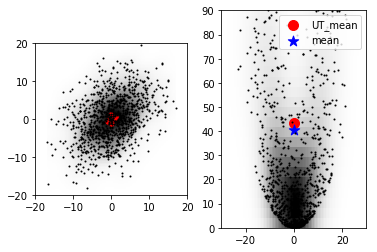

In [15]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal
from filterpy.kalman import unscented_transform
from filterpy.kalman import MerweScaledSigmaPoints as SigmaPoints

# 非线性变换函数
def f_nonlinear_xy(x, y):
    return np.array([x + y, 0.1*x**2 + y**2])
def plot1(xs, ys):
    
    xs = np.asarray(xs) 
    ys = np.asarray(ys)
    xmin = xs.min()
    xmax = xs.max()
    ymin = ys.min()
    ymax = ys.max()
    values = np.vstack([xs, ys])  
    kernel = stats.gaussian_kde(values)   
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel.evaluate(positions).T, X.shape)  
    plt.imshow(np.rot90(Z),cmap=plt.cm.Greys,extent=[xmin, xmax, ymin, ymax])
    plt.plot(xs, ys, 'k.', markersize=2)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
def plot2(xs, ys, f, mean_fx):
    
    fxs, fys = f(xs, ys)    # 将采样点进行非线性变换
    computed_mean_x = np.average(fxs)   
    computed_mean_y = np.average(fys)
    plt.subplot(121)
    plt.grid(False)
    plot1(xs, ys)
    plt.subplot(122)
    plt.grid(False)
    plot1(fxs, fys)
    plt.scatter(fxs, fys, marker='.', alpha=0.01, color='k')
    plt.scatter(mean_fx[0], mean_fx[1], marker='o', s=100, c='r', label='UT_mean')
    plt.scatter(computed_mean_x, computed_mean_y, marker='*',s=120, c='b', label='mean')
    plt.ylim([-10, 200])
    plt.xlim([-100, 100])
    plt.legend(loc='best', scatterpoints=1)
    print ('Difference in mean x={:.3f}, y={:.3f}'.format(
    computed_mean_x-mean_fx[0], computed_mean_y-mean_fx[1]))

mean = [0, 0]               # Mean of the N-dimensional distribution.
cov = [[32, 15], [15, 40]]  # Covariance matrix of the distribution.
 
# create sigma points(2n+1个sigma点)
# uses 3 parameters to control how the sigma points are distributed and weighted
points = SigmaPoints(n=2, alpha=.1, beta=2., kappa=1.)  

Wm=points.Wm
Wc=points.Wc
sigmas = points.sigma_points(mean, cov)
 
# pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1]) 
 
#unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, Wm, Wc)
 
# generate random points
xs, ys = multivariate_normal(mean, cov, size=1000).T  # 从二维随机变量的正态分布中产生1000个数据点
plot2(xs, ys, f_nonlinear_xy, ukf_mean)

# 画sigma点
plt.xlim(-30, 30); plt.ylim(0, 90)
plt.subplot(121)
plt.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30) 
plt.show()